In [ ]:
!pip install git+https://github.com/WildlifeDatasets/wildlife-datasets@develop
!pip install git+https://github.com/WildlifeDatasets/wildlife-tools

  Cloning https://github.com/WildlifeDatasets/wildlife-datasets (to revision develop) to /tmp/pip-req-build-zb1po61l
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-datasets /tmp/pip-req-build-zb1po61l
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/WildlifeDatasets/wildlife-datasets to commit 753d9bf64861c3e17011136b3436bf58bf02317f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/WildlifeDatasets/wildlife-tools to /tmp/pip-req-build-nawrcvs6
  Running command git clone --filter=blob:none --quiet https://github.com/WildlifeDatasets/wildlife-tools /tmp/pip-req-build-nawrcvs6
  Resolved https://github.com/WildlifeDatasets/wildlife-tools to commit 71aa4656d16afe4caae6d

In [ ]:

import sys
sys.modules.pop('datasets', None)

from wildlife_datasets.datasets import AnimalCLEF2025
# from wildlife_datasets.datasets import AnimalCLEF2025

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lucialiuu","key":"8f2757325544f4493f6ecbfb3d0b0a8d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
pip install kaggle

In [ ]:
!kaggle competitions download -c animal-clef-2025
!unzip -q animal-clef-2025.zip -d ./animal-clef-2025

In [ ]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity

In [ ]:
root = './animal-clef-2025'
transform_display = T.Compose([
    T.Resize([384, 384]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

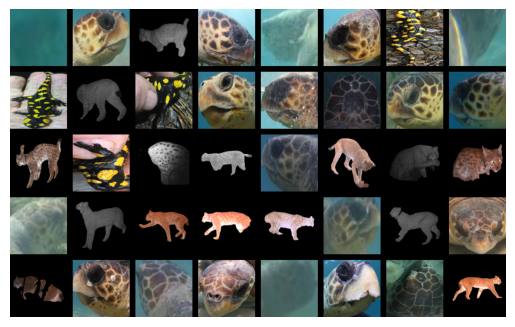

In [ ]:
dataset.plot_grid();
plt.savefig('grid_output.png', dpi=300, bbox_inches='tight')

In [ ]:
from google.colab import files
files.download("grid_output.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset.metadata

image_id            identity  \
0             0  LynxID2025_lynx_37   
1             1  LynxID2025_lynx_37   
2             2  LynxID2025_lynx_49   
3             3                 NaN   
4             4  LynxID2025_lynx_13   
...         ...                 ...   
15204     15204                 NaN   
15205     15205                 NaN   
15206     15206                 NaN   
15207     15207                 NaN   
15208     15208                 NaN   

                                                    path        date  \
0      images/LynxID2025/database/000f9ee1aad063a4485...         NaN   
1      images/LynxID2025/database/0020edb6689e9f78462...         NaN   
2      images/LynxID2025/database/003152e4145b5b69400...         NaN   
3      images/LynxID2025/query/003b89301c7b9f6d18f722...         NaN   
4      images/LynxID2025/database/003c3f82011e9c3f849...         NaN   
...                                                  ...         ...   
15204  images/SeaTurtleID2022/query/images/fecd2dfed0...  2024-06-07   
15205  images/SeaTurtleID2022/query/images/ff1a0c812b...  2023-06-28   
15206  images/SeaTurtleID2022/query/images/ff22f1cfa6...  2024-06-09   
15207  images/SeaTurtleID2022/query/images/ff5d5116d1...  2023-06-21   
15208  images/SeaTurtleID2022/query/images/ff7f522363...  2023-06-13   

      orientation            species     split          dataset  
0           right               lynx  database       LynxID2025  
1            left               lynx  database       LynxID2025  
2            left               lynx  database       LynxID2025  
3            back               lynx     query       LynxID2025  
4           right               lynx  database       LynxID2025  
...           ...                ...       ...              ...  
15204         NaN  loggerhead turtle     query  SeaTurtleID2022  
15205         NaN  loggerhead turtle     query  SeaTurtleID2022  
15206         NaN  loggerhead turtle     query  SeaTurtleID2022  
15207         NaN  loggerhead turtle     query  SeaTurtleID2022  
15208         NaN  loggerhead turtle     query  SeaTurtleID2022  

[15209 rows x 8 columns]

In [ ]:
i=dataset.metadata[dataset.metadata['dataset']=="SeaTurtleID2022"]
i['species'].unique()

array(['loggerhead turtle'], dtype=object)

Known and unknown species, and their specific species

In [ ]:
dataset.metadata['split'].value_counts()

split
database    13074
query        2135
Name: count, dtype: int64

In [ ]:
dataset.metadata.groupby(['dataset','split']).size()

dataset           split   
LynxID2025        database    2957
                  query        946
SalamanderID2025  database    1388
                  query        689
SeaTurtleID2022   database    8729
                  query        500
dtype: int64

In [ ]:
def plot_by_dataset_and_identity(dataset, prefix, identity_is_null=None, max_imgs=40):
    meta = dataset.metadata

    idx = meta['dataset'] == prefix

    if identity_is_null is True:
        idx = idx & meta['identity'].isnull()
    elif identity_is_null is False:
        idx = idx & meta['identity'].notnull()

    selected_idx = idx[idx].index

    if len(selected_idx) == 0:
        print(f"[INFO] No matching images for dataset='{prefix}', identity_is_null={identity_is_null}")
        return

    if max_imgs is not None:
        selected_idx = selected_idx[:max_imgs]

    dataset.plot_grid(idx=selected_idx)


Unkown species

In [ ]:
for pre in dataset.metadata['dataset'].unique():
  plot_by_dataset_and_identity(dataset, pre, identity_is_null=True)

  filename = f"{pre}_unknown_individuals.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
  files.download(filename)
  plt.clf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Known seaturtle, lynx, salamander

In [ ]:
for pre in dataset.metadata['dataset'].unique():
  plot_by_dataset_and_identity(dataset, pre, identity_is_null=False)
  filename = f"{pre}_known_individuals.png"
  plt.savefig(filename, dpi=300, bbox_inches='tight')
  files.download(filename)
  plt.clf()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### EDA

In [ ]:
# Count species
species_counts = dataset.metadata['species'].value_counts()
print("\nSpecies distribution:")
print(species_counts)



Species distribution:
species
loggerhead turtle    9229
lynx                 3903
salamander            689
Name: count, dtype: int64


In [ ]:
dataset.metadata['dataset'].value_counts()

dataset
SeaTurtleID2022     9229
LynxID2025          3903
SalamanderID2025    2077
Name: count, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

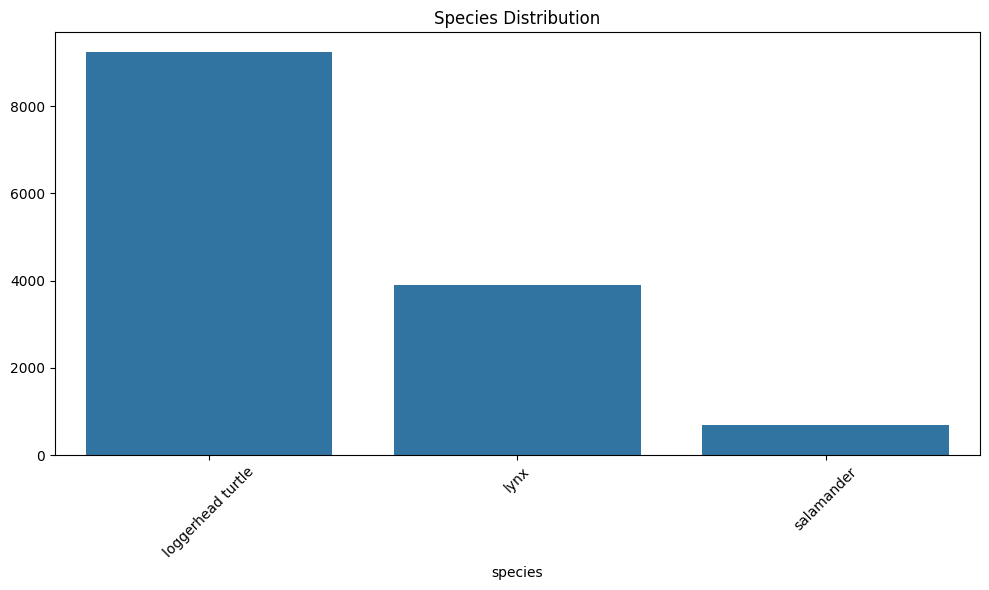

In [ ]:
# Visualize species distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=species_counts.index, y=species_counts.values)
plt.title('Species Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

filename = "species_distribution.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')

files.download(filename)

plt.show()


In [ ]:
# Count unique individuals
unique_individuals = dataset.metadata[dataset.metadata['identity'].notna()]['identity'].nunique()
print(f"\nNumber of unique individuals: {unique_individuals}")


Number of unique individuals: 1102


In [ ]:
dataset.metadata.isna().sum()

image_id          0
identity       2135
path              0
date           3907
orientation     703
species        1388
split             0
dataset           0
dtype: int64

In [ ]:
dataset.metadata[dataset.metadata["split"] == "database"].isna().sum()

image_id          0
identity          0
path              0
date           2961
orientation     203
species        1388
split             0
dataset           0
dtype: int64

In [ ]:
dataset.metadata[dataset.metadata["split"] == "query"].isna().sum()

image_id          0
identity       2135
path              0
date            946
orientation     500
species           0
split             0
dataset           0
dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

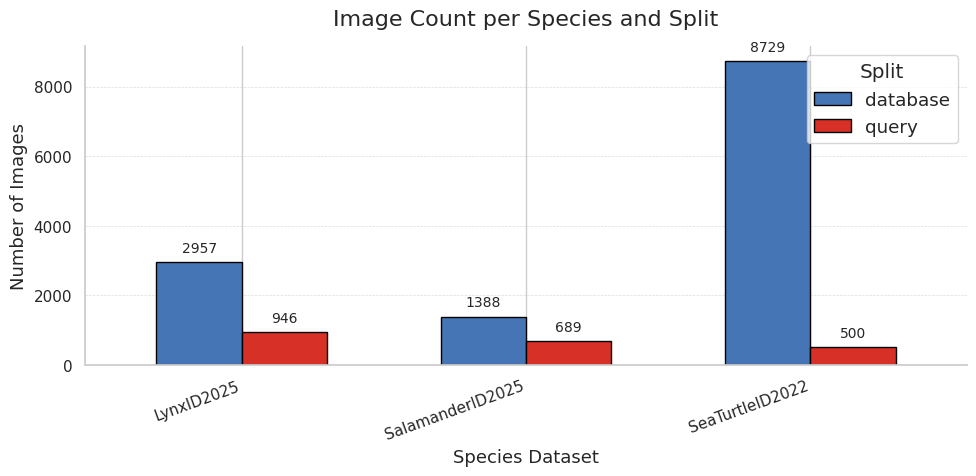

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

sns.set_theme(style="whitegrid", font_scale=1.2, rc={
    'axes.titlesize': 16,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})

class_distribution = dataset.metadata.groupby(["dataset", "split"]).size().unstack(fill_value=0)

colors = ["#4575b4", "#d73027"]  # Blue for 'database', Red for 'query'

fig, ax = plt.subplots(figsize=(10, 5))
class_distribution.plot(kind="bar", color=colors, edgecolor="black", ax=ax, width=0.6)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    xy=(p.get_x() + p.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=10)

ax.set_title("Image Count per Species and Split", pad=15)
ax.set_xlabel("Species Dataset")
ax.set_ylabel("Number of Images")


ax.legend(title="Split", loc="upper right")
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha="right")
ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)


sns.despine()
filename = "Image_Count_Per_Species_and_Split.png"
plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

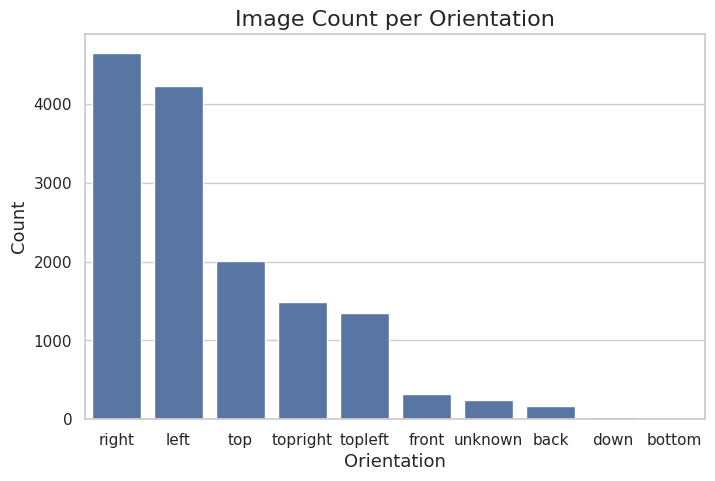

In [ ]:
# Visualizing the count of images v/s orientation

plt.figure(figsize=(8, 5))
sns.countplot(data=dataset.metadata, x="orientation", order=dataset.metadata["orientation"].value_counts().index)
plt.xlabel("Orientation")
plt.ylabel("Count")
plt.title("Image Count per Orientation")

filename = "Image_Count_per_Orientation.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

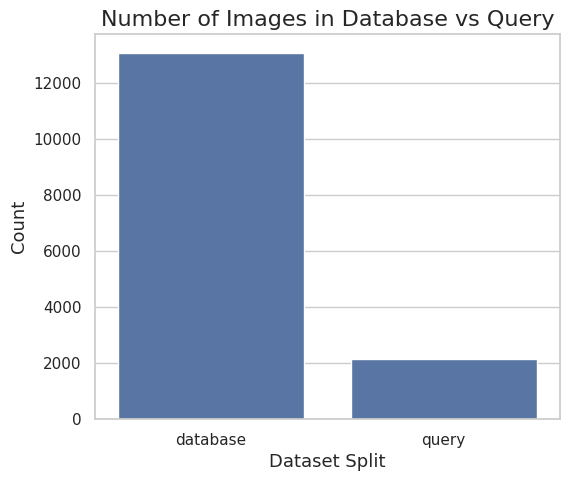

In [ ]:
# Visualizing no of images in database v/s query

plt.figure(figsize=(6, 5))
sns.countplot(data=dataset.metadata, x="split")
plt.xlabel("Dataset Split")
plt.ylabel("Count")
plt.title("Number of Images in Database vs Query")

filename = "Number_of_Images_in_Database_vs_Query.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

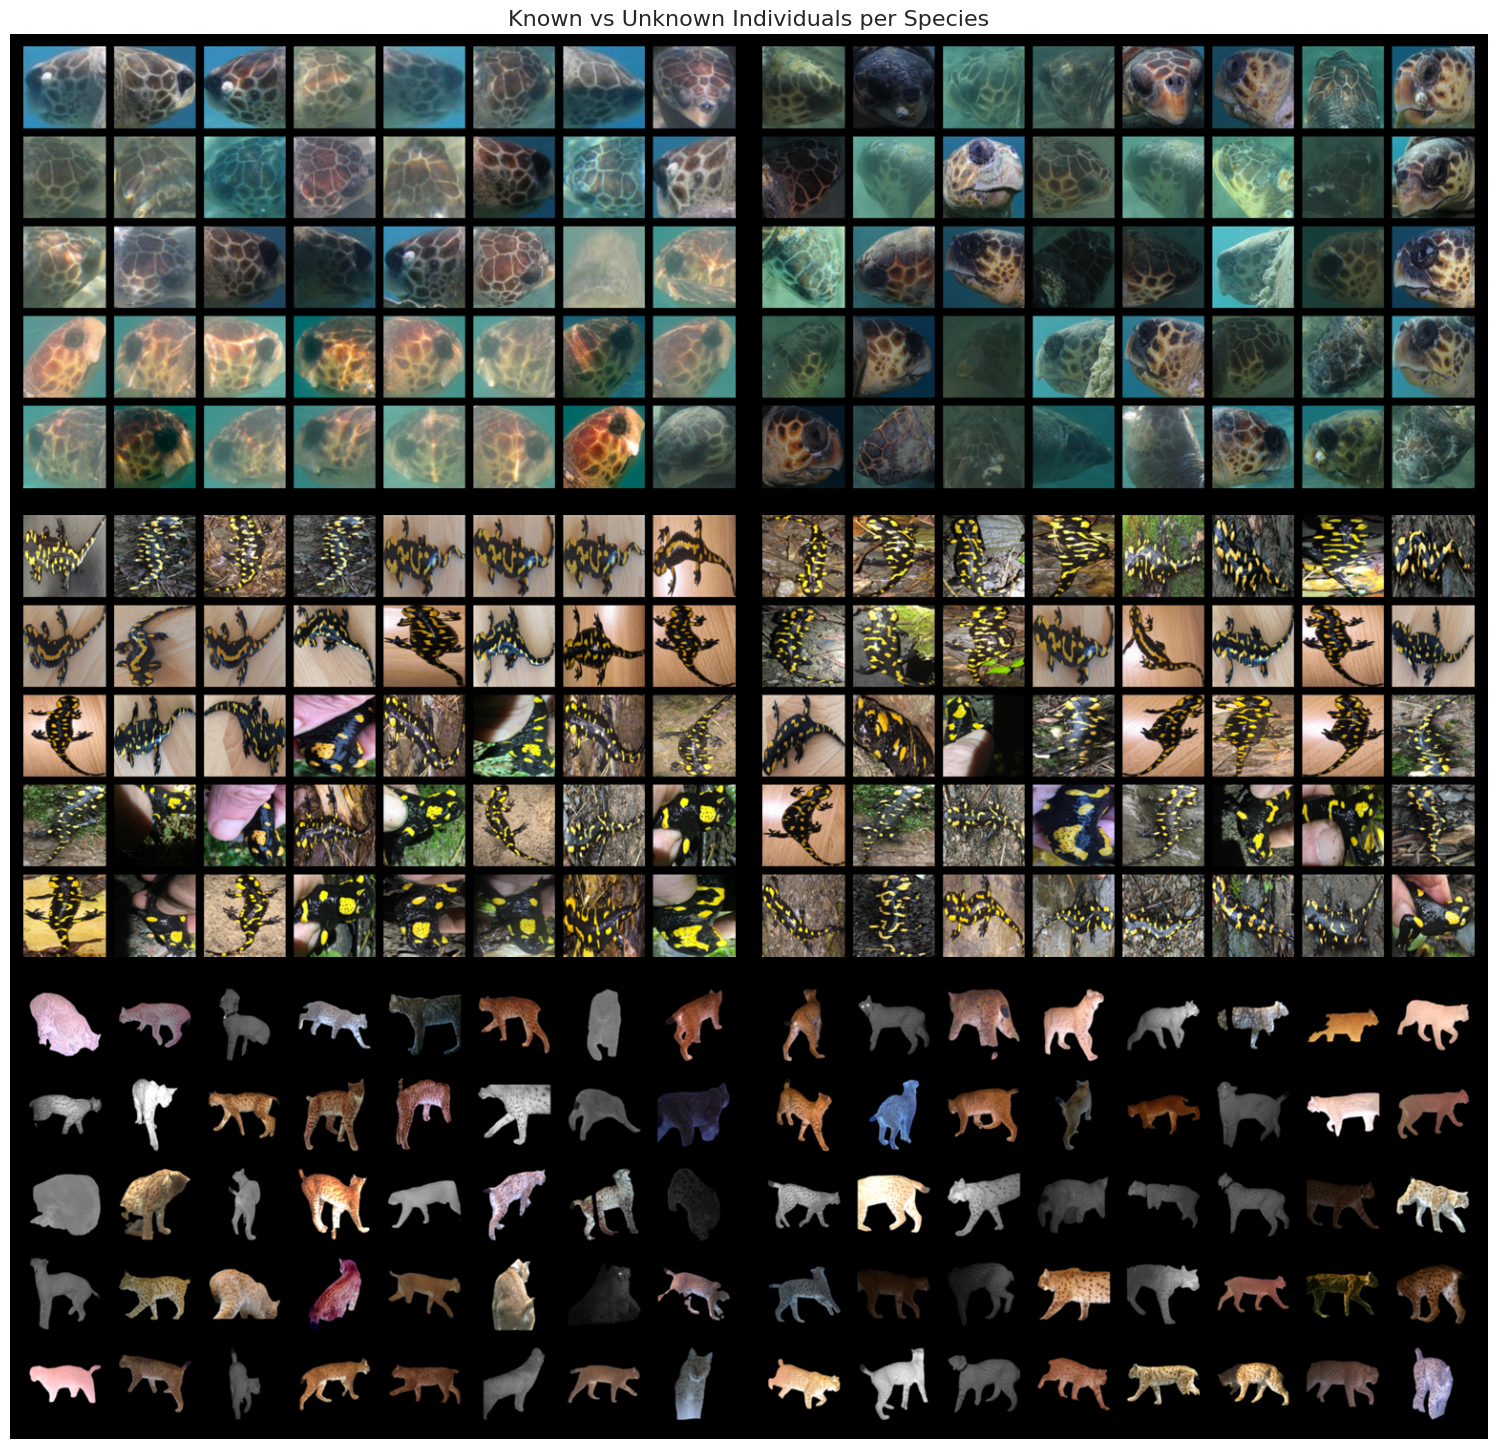

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files


img_paths = {
    'Sea Turtle': {
        'Known': 'SeaTurtleID2022_known_individuals.png',
        'Unknown': 'SeaTurtleID2022_unknown_individuals.png'
    },
    'Salamander': {
        'Known': 'SalamanderID2025_known_individuals.png',
        'Unknown': 'SalamanderID2025_unknown_individuals.png'
    },
    'Lynx': {
        'Known': 'LynxID2025_known_individuals.png',
        'Unknown': 'LynxID2025_unknown_individuals.png'
    }
}


original_imgs = {
    species: {
        status: Image.open(path)
        for status, path in paths.items()
    }
    for species, paths in img_paths.items()
}


scaled_imgs = {}
row_heights = []
row_widths = []

scale_factor = 0.5
for species in original_imgs:
    img_k = original_imgs[species]['Known']
    img_u = original_imgs[species]['Unknown']

    img_k_resized = img_k.resize((int(img_k.width * scale_factor), int(img_k.height * scale_factor)))
    img_u_resized = img_u.resize((int(img_u.width * scale_factor), int(img_u.height * scale_factor)))

    scaled_imgs[species] = {'Known': img_k_resized, 'Unknown': img_u_resized}

    row_heights.append(max(img_k_resized.height, img_u_resized.height))
    row_widths.append(img_k_resized.width + img_u_resized.width)

canvas_width = max(row_widths)
canvas_height = sum(row_heights)


combined = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

y_offset = 0
for species in ['Sea Turtle', 'Salamander', 'Lynx']:
    img_k = scaled_imgs[species]['Known']
    img_u = scaled_imgs[species]['Unknown']

    combined.paste(img_k, (0, y_offset))
    combined.paste(img_u, (img_k.width, y_offset))

    y_offset += max(img_k.height, img_u.height)


plt.figure(figsize=(canvas_width / 100, canvas_height / 100))
plt.imshow(combined)
plt.axis('off')
plt.title('Known vs Unknown Individuals per Species')
plt.tight_layout()
plt.savefig("known_vs_unknown_species.png", dpi=300)
files.download("known_vs_unknown_species.png")
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>